# Long Short-Term Memory (LSTM)

## Concise Implementation

In [1]:
using Downloads,IterTools,CUDA,Flux
using StatsBase: wsample

device = Flux.get_device(; verbose=true)

file_path = Downloads.download("http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt")
raw_text = open(io->read(io, String),file_path)
str = lowercase(replace(raw_text,r"[^A-Za-z]+"=>" "))
tokens = [str...]
vocab = unique(tokens)
vocab_len = length(vocab)

# n*[seq_length x feature x batch_size]
function getdata(str::String,vocab::Vector{Char},seq_length::Int,batch_size::Int)::Tuple
    data = collect.(partition(str,seq_length,1))
    x = [[Flux.onehotbatch(i,vocab) for i in d] for d in Flux.batchseq.(Flux.chunk(data[begin:end-1];size = batch_size))]
    y = [[Flux.onehotbatch(i,vocab) for i in d] for d in Flux.batchseq.(Flux.chunk(data[2:end];size = batch_size))]
    return x,y
end

function loss(model, xs, ys)
    Flux.reset!(model)
    return sum(Flux.logitcrossentropy.([model(x) for x in xs], ys))
end

function predict(model::Chain, prefix::String, num_preds::Int)
    model = cpu(model)
    Flux.reset!(model)
    buf = IOBuffer()
    write(buf, prefix)

    c = wsample(vocab, softmax([model(Flux.onehot(c, vocab)) for c in collect(prefix)][end]))
    for i in 1:num_preds
        write(buf, c)
        c = wsample(vocab, softmax(model(Flux.onehot(c, vocab))))
    end
    return String(take!(buf))
end

┌ Info: Using backend: CUDA.
└ @ Flux /home/nero/.julia/packages/Flux/Wz6D4/src/functor.jl:662


predict (generic function with 1 method)

Using high-level APIs, we can directly instantiate an LSTM model. This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out before.

In [ ]:
model = Chain(LSTM(vocab_len => 32),Dense(32 => vocab_len)) |> device
opt_state = Flux.setup(Adam(1e-2), model)

x,y = getdata(str, vocab, 32, 1024) |> device
data = zip(x,y)
loss_train = []

for epoch in 1:50
    Flux.reset!(model)
    Flux.train!(loss,model,data,opt_state)
    push!(loss_train,sum(loss.(Ref(model), x, y)) / length(str)) 
end

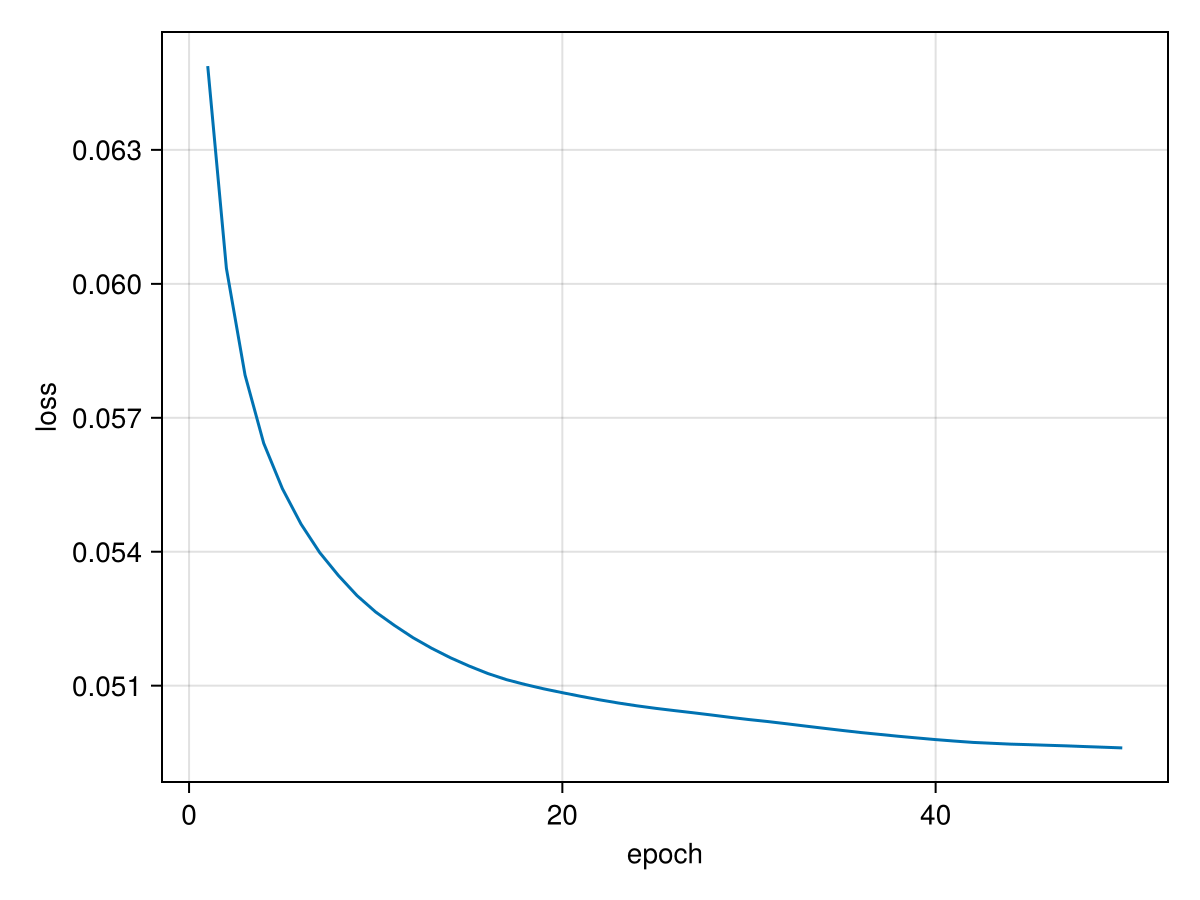

In [3]:
using CairoMakie
fg,ax = lines(loss_train; axis=(;xlabel = "epoch",ylabel = "loss"))

In [7]:
predict(model,"it has ",20)

"it has hood was but dwowleu"